# Load Tweets from JSON
This notebook collects tweets from the Twitter API and stores them in a Spark DataFrame or RDD.

<font color='red' size=16> Mount Drive before running cell </font>

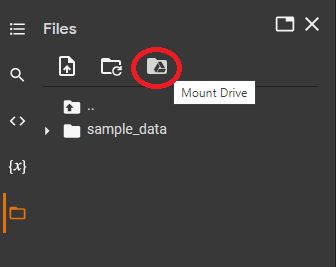

In [1]:
# copy Tweets JSON file over from MyDrive
!cp "/content/drive/MyDrive/Data+ Training/🎓 Capstone/wordle_240_tweets.json" /content/tweets.json

# Set up Spark Context

## Install Spark

In [2]:
!pip install -q pyspark
!pip install -q py4j
!pip install -q findspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless &> /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.1 MB/s eta 0:00:00


In [3]:
import findspark
import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

findspark.init()

## Start Spark Context

In [4]:
from pyspark import SparkContext, SparkConf, SQLContext

sc = SparkContext(master="local[*]", appName="WordleTweets").getOrCreate()
sc.setLogLevel("ERROR")

In [5]:
print(sc)

<SparkContext master=local[*] appName=WordleTweets>


# Create SparkSQL context

In [6]:
sqlContext = SQLContext(sc)
df = sqlContext.read.json("tweets.json")
df.show(12)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------------+-----------+--------------------+--------------------+-----------------+--------------+---------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+------------+-----+------------------+-------------+---------+--------------------+--------------------+--------------------------+---------+--------------------+
|contributors|coordinates|          created_at|            entities|extended_entities|favorite_count|favorited| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|    metadata|place|possibly_sensitive|retweet_count|retweeted|    retweeted_status|              source|                      text|truncated|                user|
+------------+-----------+--------------------+--------------------+-----------------+--

In [7]:
import json
with open('schema.json', 'w') as outfile:
    json.dump(df.schema.json(), outfile, indent=1)

In [8]:
df.filter(df["entities"]['user_mentions'] != None).show(3)

+------------+-----------+----------+--------+-----------------+--------------+---------+---+---+------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+--------+-----+------------------+-------------+---------+----------------+------+----+---------+----+
|contributors|coordinates|created_at|entities|extended_entities|favorite_count|favorited|geo| id|id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|metadata|place|possibly_sensitive|retweet_count|retweeted|retweeted_status|source|text|truncated|user|
+------------+-----------+----------+--------+-----------------+--------------+---------+---+---+------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+--------+-----+------------------+-------------+---------+-------------

## Add column to Spark DF

In [9]:
# Count engagement
df.withColumn("engagement", df['favorite_count'] + df['retweet_count']).show(5)

+------------+-----------+--------------------+--------------------+-----------------+--------------+---------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+------------+-----+------------------+-------------+---------+--------------------+--------------------+--------------------+---------+--------------------+----------+
|contributors|coordinates|          created_at|            entities|extended_entities|favorite_count|favorited| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|    metadata|place|possibly_sensitive|retweet_count|retweeted|    retweeted_status|              source|                text|truncated|                user|engagement|
+------------+-----------+--------------------+--------------------+----------

# Spark DF to Pandas

In [10]:
from datetime import datetime
from dateutil.parser import parse

timestamps_df = df.groupby("created_at").count().toPandas()
# convert Twitter date to datetime
timestamps_df["day_created"] = timestamps_df["created_at"].apply(lambda x: parse(x).date())

In [11]:
timestamps_df.day_created

0     2022-03-04
1     2022-02-26
2     2022-03-02
3     2022-03-04
4     2022-03-03
5     2022-03-02
6     2022-03-01
7     2022-02-27
8     2022-02-28
9     2022-03-03
10    2022-03-03
11    2022-03-03
12    2022-02-25
13    2022-02-27
14    2022-03-01
15    2022-03-04
16    2022-03-02
17    2022-02-25
18    2022-03-02
19    2022-03-04
20    2022-02-27
21    2022-02-27
22    2022-03-04
23    2022-03-01
24    2022-03-04
25    2022-03-04
26    2022-03-03
27    2022-02-26
28    2022-02-28
29    2022-03-03
30    2022-03-01
31    2022-02-27
32    2022-03-01
33    2022-02-26
34    2022-02-26
35    2022-03-04
36    2022-02-26
37    2022-02-25
38    2022-02-27
39    2022-02-27
40    2022-02-26
41    2022-02-26
42    2022-02-26
43    2022-02-26
44    2022-03-02
45    2022-03-04
46    2022-02-27
47    2022-03-02
48    2022-03-01
49    2022-03-01
50    2022-03-01
51    2022-02-27
52    2022-02-26
53    2022-03-03
54    2022-02-27
Name: day_created, dtype: object

In [12]:
timestamps_df["day_created"].min()

datetime.date(2022, 2, 25)

In [13]:
timestamps_df["day_created"].max()

datetime.date(2022, 3, 4)

---

# Pandas to Matplotlib

In [14]:
timestamps_df

,created_at,count,day_created
0,Fri Mar 04 21:35:32 +0000 2022,1,2022-03-04
1,Sat Feb 26 00:49:16 +0000 2022,1,2022-02-26
2,Wed Mar 02 05:13:07 +0000 2022,1,2022-03-02
3,Fri Mar 04 16:59:28 +0000 2022,1,2022-03-04
4,Thu Mar 03 17:56:43 +0000 2022,1,2022-03-03
5,Wed Mar 02 00:56:58 +0000 2022,1,2022-03-02
6,Tue Mar 01 20:50:18 +0000 2022,1,2022-03-01
7,Sun Feb 27 16:11:57 +0000 2022,1,2022-02-27
8,Mon Feb 28 01:10:44 +0000 2022,1,2022-02-28
9,Thu Mar 03 17:49:21 +0000 2022,1,2022-03-03


In [15]:
timestamps_df.groupby(by='day_created').sum('count')

,count
day_created,
2022-02-25,3
2022-02-26,10
2022-02-27,10
2022-02-28,2
2022-03-01,8
2022-03-02,6
2022-03-03,7
2022-03-04,9


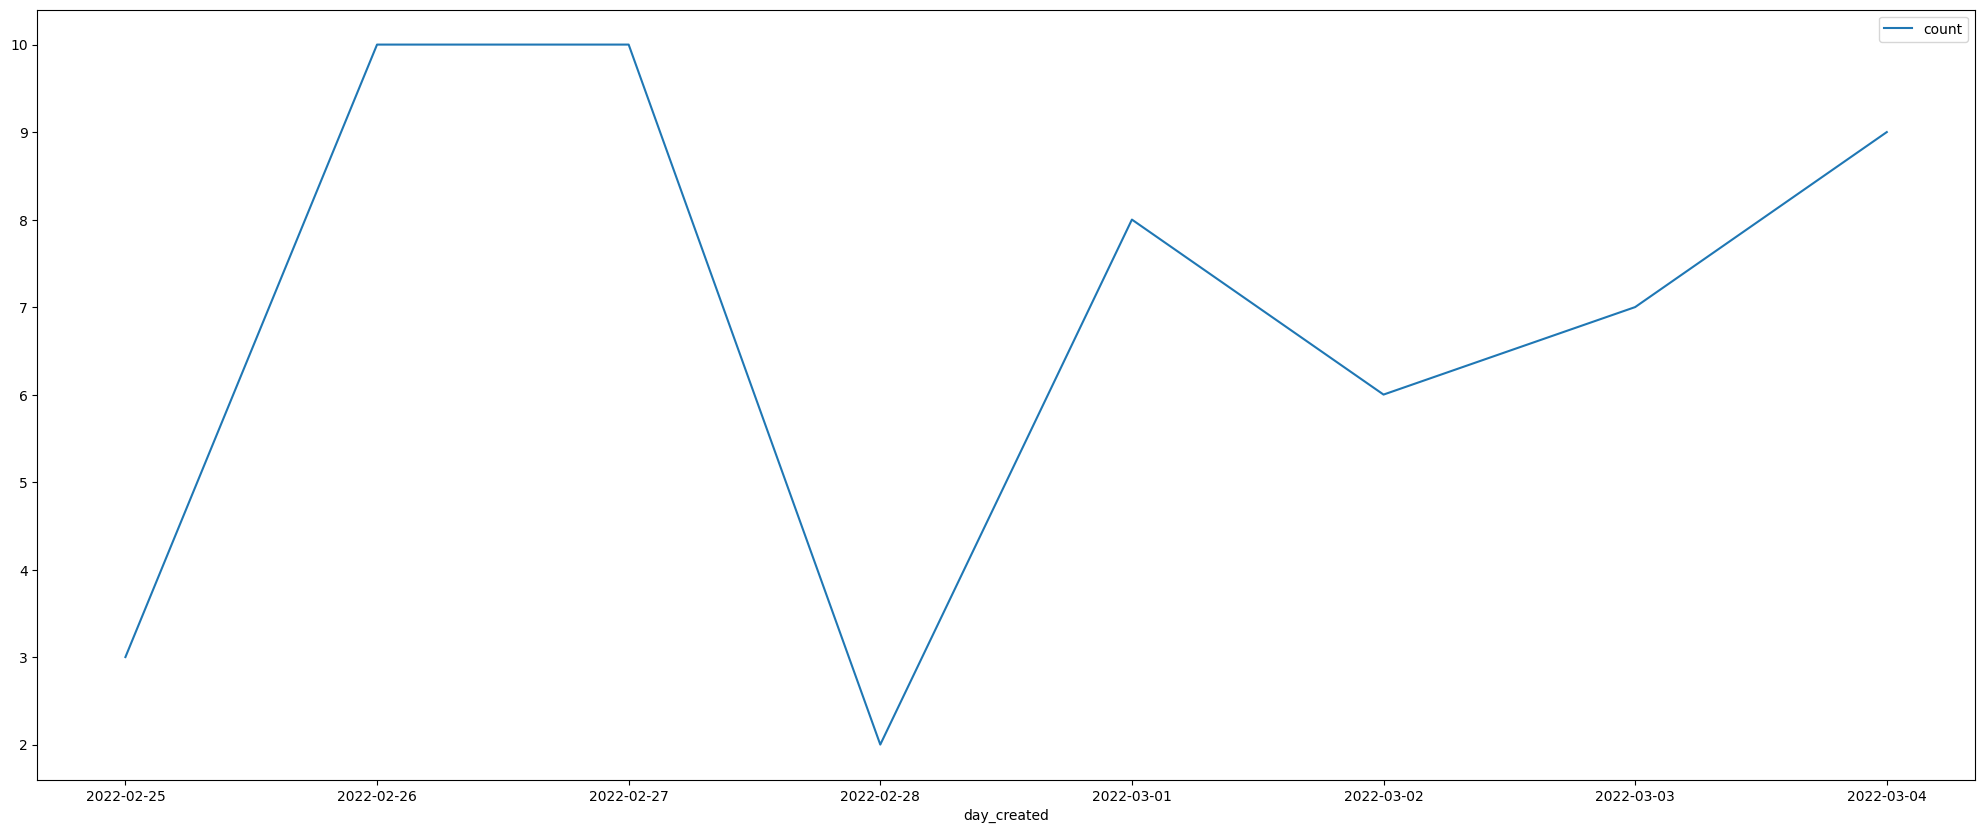

In [16]:
import matplotlib.pyplot as plt
from datetime import date

fig, ax = plt.subplots(figsize=(25,10))

# days = (timestamps_df.day_created.max() - timestamps_df.day_created.min()).days

timestamps_df.groupby(by='day_created').sum('count').plot(kind='line', y="count", ax=ax);
# timestamps_df.groupby(by="day_created").count().reset_index().plot(kind='hist', x='day_created', y='count', bins = days+1, ax=ax);

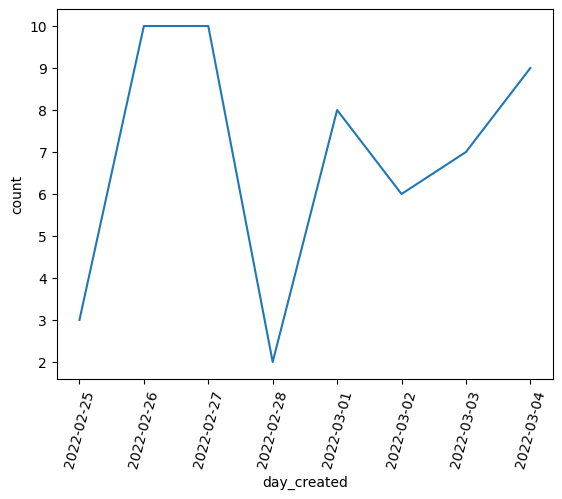

In [17]:
import seaborn as sns

viz_df = timestamps_df.groupby(by="day_created").count()
sns.lineplot(data=viz_df, x=viz_df.index, y='count').tick_params(axis='x', rotation=75);

In [18]:
timestamps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   created_at   55 non-null     object
 1   count        55 non-null     int64 
 2   day_created  55 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.4+ KB


In [19]:
pandas_df = df.select("created_at", "text", "favorite_count", "retweet_count", "lang").toPandas()

In [20]:
pandas_df.iloc[0]

created_at                      Fri Mar 04 23:16:29 +0000 2022
text              Wordle 230 4/6\n\n⬛🟨⬛⬛🟨\n🟨🟨⬛🟨⬛\n🟩🟨🟨🟩🟨\n🟩🟩🟩🟩🟩
favorite_count                                               0
retweet_count                                                0
lang                                                        en
Name: 0, dtype: object

In [21]:
pandas_df.iloc[0].text

'Wordle 230 4/6\n\n⬛🟨⬛⬛🟨\n🟨🟨⬛🟨⬛\n🟩🟨🟨🟩🟨\n🟩🟩🟩🟩🟩'

In [22]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      55 non-null     object
 1   text            55 non-null     object
 2   favorite_count  55 non-null     int64 
 3   retweet_count   55 non-null     int64 
 4   lang            55 non-null     object
dtypes: int64(2), object(3)
memory usage: 2.3+ KB


# Convert `created_at` to `datetime`

In [23]:
from datetime import datetime
from dateutil.parser import parse

with open('tweets.json', 'r+') as infile:
    for tweet in infile:
        tweet["created_at"] = str(parse(tweet["created_at"]))
    

TypeError: ignored